# Tests with 2D annotations from Basile
Annotations consist of an image of the volume concatenated Z axis (axis 0) using colors to represent depth. Cytonèmes where annotated and starting and ending pixel were saved for comparisons.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tifffile as tif
from scipy.stats import ks_2samp

# Analyse Basile 2D annotation

In [3]:
pipeline_csv = "../data/output/slik3_unet2D.csv"  # pipeline results
data_txt =     "../data/drawn_cyto/slik3.txt"  # Basile hand drawn cyto
data_img =     "../data/drawn_cyto/slik3.tif"  # z projection img

viz_data_txt = 1  # show data_txt plot over data_img

pipeline_df = pd.read_csv(pipeline_csv)
data_df = pd.read_csv(data_txt, sep="\t")

# transform pipeline dataframe to have same format as data
id, xi, yi, xf, yf, length = data_df.columns
transformed_map = {c:[] for c in data_df.columns}
for path_id in pipeline_df["path_id"].unique():
    path = pipeline_df[pipeline_df["path_id"] == path_id]
    id, xi, yi, xf, yf, length = data_df.columns
    _, _, _, pid, x1, y1, z1, _, l1 = path.iloc[0]
    _, _, _, pid, x2, y2, z2, _, l2 = path.iloc[-1]
    transformed_map[id].append(path_id)
    transformed_map[xi].append(x1)
    transformed_map[yi].append(y1)
    transformed_map[xf].append(x2)
    transformed_map[yf].append(y2)
    transformed_map[length].append(l2)

transformed_df = pd.DataFrame(transformed_map)

# filter out small cyto
transformed_df = transformed_df.loc[transformed_df["Length"] >= 0.5].reset_index(drop=True)

print(len(transformed_df), "paths found with pipeline")
print(len(data_df), "paths found by hand")
print()

# match and compare paths
matches = []
used_d_path = []
for p_row in transformed_df.iloc:
    ssd = 1e9
    pid_match = None
    
    for i, d_row in enumerate(data_df.iloc):
        
        if i in used_d_path:
            continue

        xi1 = int(d_row[xi])
        yi1 = int(d_row[yi])
        xi2 = int(p_row[xi])
        yi2 = int(p_row[yi])
        xf1 = int(d_row[xf])
        yf1 = int(d_row[yf])
        xf2 = int(p_row[xf])
        yf2 = int(p_row[yf])

        distance_i = ((xi1 - xi2) ** 2 + (yi1 - yi2) ** 2) ** 0.5
        distance_f = ((xf1 - xf2) ** 2 + (yf1 - yf2) ** 2) ** 0.5
        distance = distance_i + distance_f

        if distance < ssd:
            ssd = distance
            pid_match = i # d_row[id] would have made sense if ids weren't all equal...
    
    used_d_path.append(pid_match)
    matches.append([pid_match, p_row[id], ssd])

15 paths found with pipeline
49 paths found by hand



In [4]:
# length sum, avg
print("pipeline sum {:.2f} and avg {:.2f}".format(transformed_df["Length"].sum(), transformed_df["Length"].mean()))
print("data sum {:.2f} and avg {:.2f}".format(data_df["Length"].sum(), data_df["Length"].mean()))

pipeline sum 127.98 and avg 8.53
data sum 277.45 and avg 5.66


In [5]:
srt_data = data_df.sort_values("Length").reset_index(drop=True)
srt_pipe = transformed_df.sort_values("Length").reset_index(drop=True)

tmp = srt_data.append(srt_pipe)["Length"]
mn = tmp.min()
mx = tmp.max() + 1e-7
nbins = 11
xax = np.linspace(mn, mx, nbins)

bins_data = []
bins_pipe = []

for i in range(nbins - 1):
    between = (srt_data["Length"] >= xax[i]) & (srt_data["Length"] < xax[i+1])
    bins_data.append(len(np.where(between)[0]))
    between = (srt_pipe["Length"] >= xax[i]) & (srt_pipe["Length"] < xax[i+1])
    bins_pipe.append(len(np.where(between)[0]))

In [6]:
print(xax, len(xax))
print(bins_data, len(bins_data))
print(bins_pipe, len(bins_pipe))

[ 0.9891      3.77872001  6.56834002  9.35796003 12.14758004 14.93720005
 17.72682006 20.51644007 23.30606008 26.09568009 28.8853001 ] 11
[20, 14, 10, 1, 2, 0, 0, 1, 1, 0] 10
[7, 1, 1, 1, 2, 2, 0, 0, 0, 1] 10


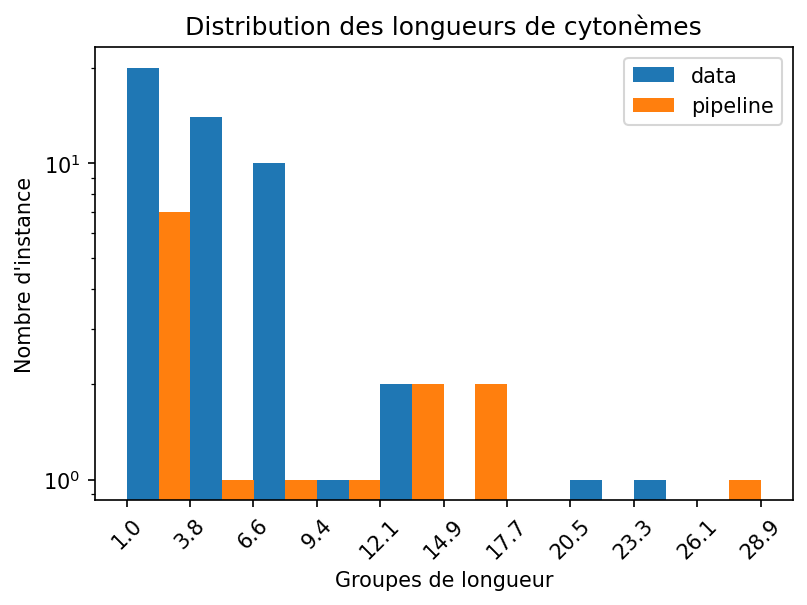

In [7]:
width = 1.4

plt.figure(figsize=(6,4), dpi=150)
rects1 = plt.bar(width + xax[:-1] - width / 2, bins_data, width, label="data")
rects2 = plt.bar(width + xax[:-1] + width / 2, bins_pipe, width, label="pipeline")
plt.xlabel("Groupes de longueur")
plt.ylabel("Nombre d'instance")
plt.legend()
plt.title("Distribution des longueurs de cytonèmes")

plt.yscale('log')
plt.xticks(xax, [round(i, 1) for i in xax], rotation=45)
plt.show()

Ks_2sampResult(statistic=0.3, pvalue=0.7869297884777761)


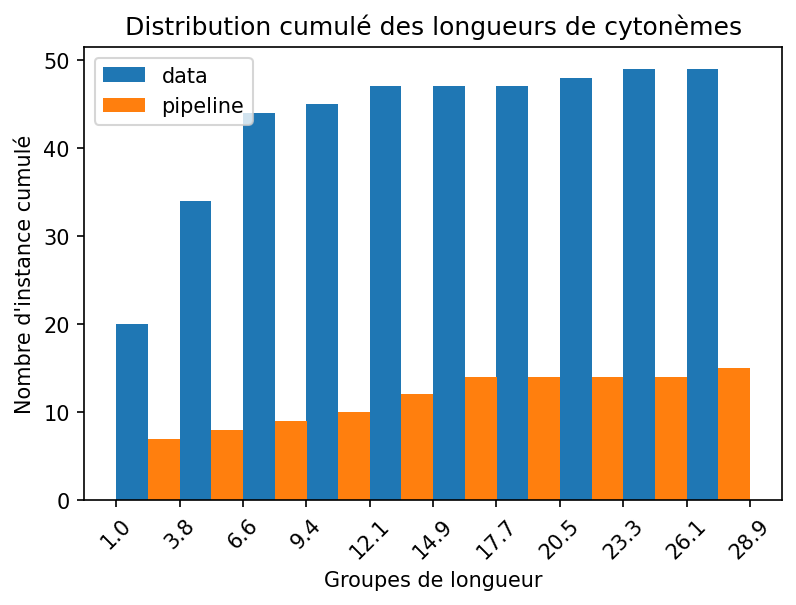

In [8]:
# as requested, Kolmogorov-Smirnov metric (I think)
print(ks_2samp(bins_data, bins_pipe))
plt.figure(figsize=(6,4), dpi=150)
rects1 = plt.bar(width + xax[:-1] - width / 2, np.cumsum(bins_data), width, label="data")
rects2 = plt.bar(width + xax[:-1] + width / 2, np.cumsum(bins_pipe), width, label="pipeline")
plt.xlabel("Groupes de longueur")
plt.ylabel("Nombre d'instance cumulé")
plt.legend()
plt.title("Distribution cumulé des longueurs de cytonèmes")

#plt.yscale('log')
plt.xticks(xax, [round(i, 1) for i in xax], rotation=45)
plt.show()